In [9]:
import pandas as pd

engagement = pd.read_csv("/Users/sarahberkin/Downloads/relax_challenge/takehome_user_engagement.csv", parse_dates=['time_stamp'])
users = pd.read_csv("/Users/sarahberkin/Downloads/relax_challenge/takehome_users.csv", encoding='latin-1')

# Group by user_id and sort
engagement = engagement.sort_values(['user_id', 'time_stamp'])

# For each user, check for any 3 logins within a 7-day window
adopted_users = set()

for user_id, df in engagement.groupby('user_id'):
    dates = df['time_stamp'].sort_values()
    for i in range(len(dates) - 2):
        if (dates.iloc[i + 2] - dates.iloc[i]).days <= 7:
            adopted_users.add(user_id)
            break

users['adopted'] = users['object_id'].apply(lambda x: 1 if x in adopted_users else 0)

In [10]:
# Convert timestamps
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

# Feature engineering
users['days_since_creation'] = (pd.Timestamp.now() - users['creation_time']).dt.days
users['days_since_last_session'] = (pd.Timestamp.now() - users['last_session_creation_time']).dt.days
users['invited'] = users['invited_by_user_id'].notnull().astype(int)

# One-hot encodeimport seaborn as sns

         opted_in_to_mailing_list  enabled_for_marketing_drip  \
adopted                                                         
0                        0.247970                    0.148395   
1                        0.259058                    0.155193   

         days_since_creation  days_since_last_session   invited  \
adopted                                                           
0                4261.246133              4250.029999  0.529196   
1                4315.393720              4022.885870  0.569444   

         creation_source_ORG_INVITE  creation_source_PERSONAL_PROJECTS  \
adopted                                                                  
0                          0.355762                           0.187452   
1                          0.346618                           0.103865   

         creation_source_SIGNUP  creation_source_SIGNUP_GOOGLE_AUTH  
adopted                                                              
0                      0.172564  

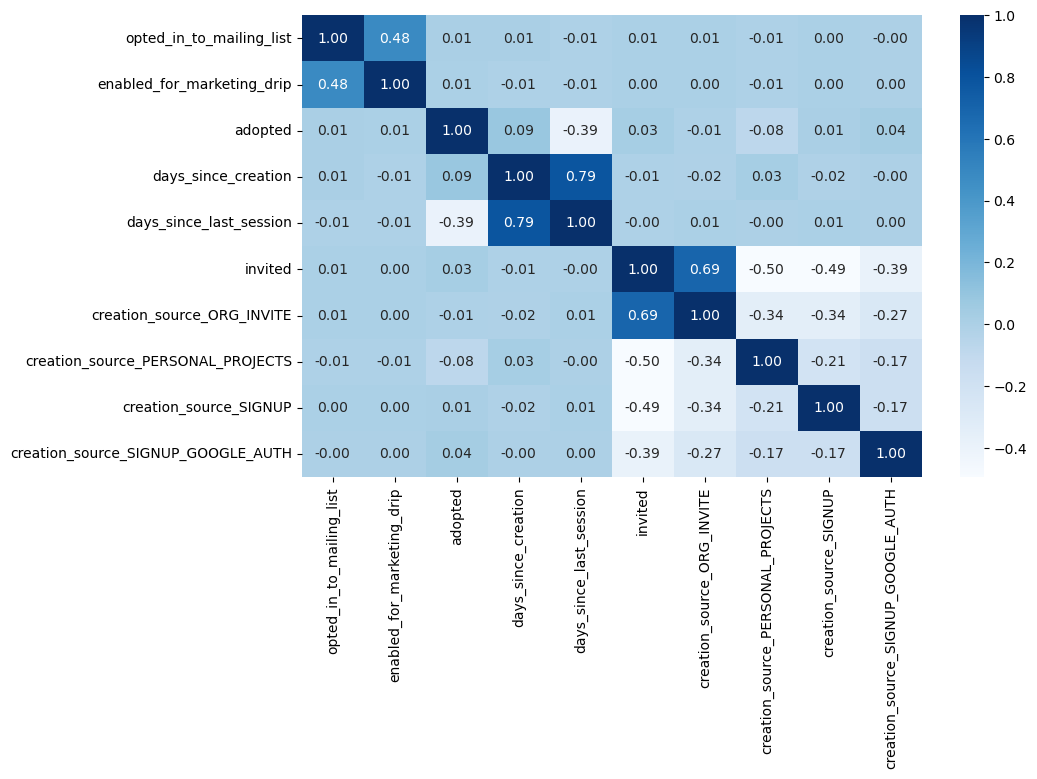

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare means
print(users_model.groupby('adopted').mean())

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(users_model.corr(), annot=True, fmt=".2f", cmap="Blues")
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2586
           1       0.90      0.82      0.86       414

    accuracy                           0.96      3000
   macro avg       0.94      0.90      0.92      3000
weighted avg       0.96      0.96      0.96      3000



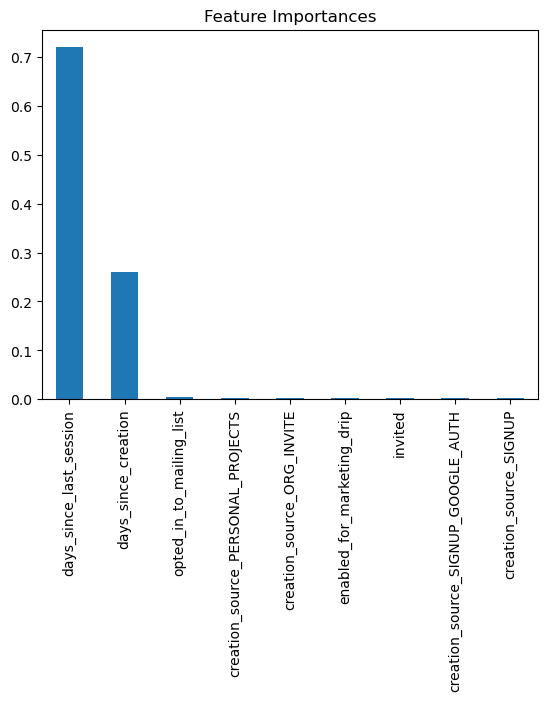

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = users_model.drop(columns='adopted')
y = users_model['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test)))

feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar')
plt.title("Feature Importances")
plt.show()

In [21]:
# Helper function
def adoption_rate_by_feature(df, feature):
    return df.groupby(feature)['adopted'].agg(['count', 'sum', 'mean']).rename(columns={'sum': 'adopted_users', 'mean': 'adoption_rate'}).sort_values(by='adoption_rate', ascending=False)

# Creation source
print(adoption_rate_by_feature(users, 'creation_source'))

# Invited vs not
print(adoption_rate_by_feature(users, 'invited'))

# Opted into mailing list?
print(adoption_rate_by_feature(users, 'opted_in_to_mailing_list'))

# Enabled for marketing drip?
print(adoption_rate_by_feature(users, 'enabled_for_marketing_drip'))

                    count  adopted_users  adoption_rate
creation_source                                        
SIGNUP_GOOGLE_AUTH   1385            239       0.172563
GUEST_INVITE         2163            369       0.170596
SIGNUP               2087            302       0.144705
ORG_INVITE           4254            574       0.134932
PERSONAL_PROJECTS    2111            172       0.081478
         count  adopted_users  adoption_rate
invited                                     
1         6417            943       0.146953
0         5583            713       0.127709
                          count  adopted_users  adoption_rate
opted_in_to_mailing_list                                     
1                          2994            429       0.143287
0                          9006           1227       0.136243
                            count  adopted_users  adoption_rate
enabled_for_marketing_drip                                     
1                            1792            257    

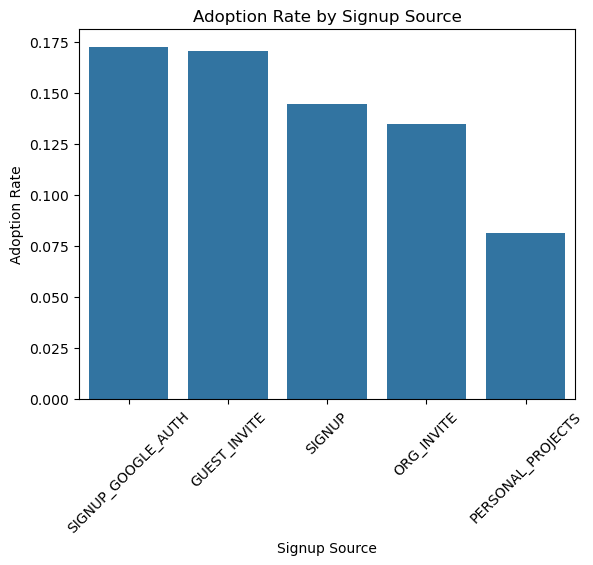

In [23]:
# Visualize
source_plot = adoption_rate_by_feature(users, 'creation_source').reset_index()
sns.barplot(data=source_plot, x='creation_source', y='adoption_rate')
plt.title("Adoption Rate by Signup Source")
plt.ylabel("Adoption Rate")
plt.xlabel("Signup Source")
plt.xticks(rotation=45)
plt.show()